<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, MultiTaskLassoCV, LassoCV
from math import exp

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 150)


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')
print(house.shape)

(1460, 81)


In [4]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Checking and Cleaning

### 1. Check Data Types

In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

#### Observations

Data types match with data dictionary descriptions

### 2. Check Values

##### 2.a check unique values for object columns

In [6]:
# create df of object types only
ob_house = house.select_dtypes(include=object)

# for every column in df print unique values
for col in ob_house:
    print(col)
    print(ob_house[col].sort_values().unique())

MSZoning
['C (all)' 'FV' 'RH' 'RL' 'RM']
Street
['Grvl' 'Pave']
Alley
['Grvl' 'Pave' nan]
LotShape
['IR1' 'IR2' 'IR3' 'Reg']
LandContour
['Bnk' 'HLS' 'Low' 'Lvl']
Utilities
['AllPub' 'NoSeWa']
LotConfig
['Corner' 'CulDSac' 'FR2' 'FR3' 'Inside']
LandSlope
['Gtl' 'Mod' 'Sev']
Neighborhood
['Blmngtn' 'Blueste' 'BrDale' 'BrkSide' 'ClearCr' 'CollgCr' 'Crawfor'
 'Edwards' 'Gilbert' 'IDOTRR' 'MeadowV' 'Mitchel' 'NAmes' 'NPkVill'
 'NWAmes' 'NoRidge' 'NridgHt' 'OldTown' 'SWISU' 'Sawyer' 'SawyerW'
 'Somerst' 'StoneBr' 'Timber' 'Veenker']
Condition1
['Artery' 'Feedr' 'Norm' 'PosA' 'PosN' 'RRAe' 'RRAn' 'RRNe' 'RRNn']
Condition2
['Artery' 'Feedr' 'Norm' 'PosA' 'PosN' 'RRAe' 'RRAn' 'RRNn']
BldgType
['1Fam' '2fmCon' 'Duplex' 'Twnhs' 'TwnhsE']
HouseStyle
['1.5Fin' '1.5Unf' '1Story' '2.5Fin' '2.5Unf' '2Story' 'SFoyer' 'SLvl']
RoofStyle
['Flat' 'Gable' 'Gambrel' 'Hip' 'Mansard' 'Shed']
RoofMatl
['ClyTile' 'CompShg' 'Membran' 'Metal' 'Roll' 'Tar&Grv' 'WdShake'
 'WdShngl']
Exterior1st
['AsbShng' 'AsphShn'

#### Observations

MSZoning - what is 'c (all)' not specified in the data dictionary

Neighborhood - 'NAmes' spelt incorrectly, should be 'Names'

BldgType - 'Twnhs' not in data dictionary, maybe mispelt 'TwnhsI'

Exterior2nd - 'Wd Shng' not in data dictionary, missplet either 'Wd Sdng' or 'WdShing'

Electrical - NA not an option


In [7]:
# fix spelling mistakes
house['Neighborhood'].replace('NAmes','Names', inplace=True)
house['BldgType'].replace('Twnhs','TwnhsI', inplace=True)
house['BldgType'].replace('Wd Shng','Wd Sdng', inplace=True)

##### 2.b check unique values for int categorical columns

In [8]:
# create df of int categorical columns only
int_cat_house = house[['MSSubClass', 'OverallQual', 'OverallCond','MoSold', 'YrSold','YearBuilt']]

# for every column in df print unique values
for col in int_cat_house:
    print(col)
    print(int_cat_house[col].sort_values().unique())

MSSubClass
[ 20  30  40  45  50  60  70  75  80  85  90 120 160 180 190]
OverallQual
[ 1  2  3  4  5  6  7  8  9 10]
OverallCond
[1 2 3 4 5 6 7 8 9]
MoSold
[ 1  2  3  4  5  6  7  8  9 10 11 12]
YrSold
[2006 2007 2008 2009 2010]
YearBuilt
[1872 1875 1880 1882 1885 1890 1892 1893 1898 1900 1904 1905 1906 1908
 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923
 1924 1925 1926 1927 1928 1929 1930 1931 1932 1934 1935 1936 1937 1938
 1939 1940 1941 1942 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954
 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968
 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982
 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010]


#### Observations

All columns match with Data Dictionary


##### 2.c check for null values

In [9]:
null_val = house.isnull().sum()
df_null = pd.DataFrame(null_val)
df_null['entries'] = 1460 #number of entries
df_null['missing_percent'] = (df_null[0]/df_null['entries'])*100
isnull = df_null[df_null[0] != 0] # only show variables with null values
isnull

,0,entries,missing_percent
LotFrontage,259,1460,17.739726
Alley,1369,1460,93.767123
MasVnrType,8,1460,0.547945
MasVnrArea,8,1460,0.547945
BsmtQual,37,1460,2.534247
BsmtCond,37,1460,2.534247
BsmtExposure,38,1460,2.602740
BsmtFinType1,37,1460,2.534247
BsmtFinType2,38,1460,2.602740
Electrical,1,1460,0.068493


#### Observations
Alley, PoolQC, Fence, MiscFeature all have more than 80% null values 

FireplaceQu has 47% null values

Will not be able to get accurate information from these variables with so much data missing- choosing to drop these variables


In [10]:
# return list of columns with more than 40% null values
null_cols = house.columns[house.isnull().sum() > len(house)*0.4]
null_cols

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [11]:
# drop ID column and null_cols
house.drop('Id', axis=1, inplace=True)
house.drop(null_cols, axis=1, inplace=True)

In [12]:
# remaining null values
null_val = house.isnull().sum()
df_null = pd.DataFrame(null_val)
df_null['entries'] = 1460 # total number of entries
df_null['missing_percent'] = (df_null[0]/df_null['entries'])*100
isnull = df_null[df_null[0] != 0] # only show variables with null values
isnull

,0,entries,missing_percent
LotFrontage,259,1460,17.739726
MasVnrType,8,1460,0.547945
MasVnrArea,8,1460,0.547945
BsmtQual,37,1460,2.534247
BsmtCond,37,1460,2.534247
BsmtExposure,38,1460,2.602740
BsmtFinType1,37,1460,2.534247
BsmtFinType2,38,1460,2.602740
Electrical,1,1460,0.068493
GarageType,81,1460,5.547945


#### Observations

replace null values in int and float columns with median values

replace null values in object columns with mode values

In [13]:
for column in house.columns:
    if house[column].dtype == 'int' or house[column].dtype == 'float':
        house[column].fillna(house[column].median(), inplace=True)
    elif house[column].dtype == 'object':
        house[column].fillna(house[column].mode()[0], inplace=True)

In [14]:
# check for any remaining null values
house.isnull().sum()


MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
                ..
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch   

In [15]:
house.shape

(1460, 75)

### 3. Filtering

##### 3.a Residential buildings only 

In [16]:
house = house[house['MSZoning'] != 'C (all)']
house = house[house['MSZoning'] != 'A']
house = house[house['MSZoning'] != 'I']
# no longer need this column now that data has been filtered to residential
house.drop('MSZoning', axis=1, inplace=True) 
house['FirstFlrSF'] = house['1stFlrSF']
house['SecFlrSF'] = house['2ndFlrSF']
house['ThreeSsnPorch'] = house['3SsnPorch']
house.drop('1stFlrSF',axis=1,inplace=True)
house.drop('2ndFlrSF',axis=1,inplace=True)
house.drop('3SsnPorch',axis=1,inplace=True)

##### 3.b identify fixed

In [17]:
# list all fixed columns
fixed = ['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour',
           'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
           'YearBuilt', 'YearRemodAdd','Foundation', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
           'TotalBsmtSF', 'FirstFlrSF', 'SecFlrSF','LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
           'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageType', 'GarageYrBlt',
           'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch',
           'PoolArea', 'YrSold','SalePrice']
house_e = house[fixed].copy()


# EDA

##### 1. Describe Data

In [18]:
house_e.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1450.0,56.903448,42.265033,20.0,20.00,50.0,70.00,190.0
LotFrontage,1450.0,69.864828,22.026045,21.0,60.00,69.0,79.00,313.0
LotArea,1450.0,10523.831724,10012.185355,1300.0,7544.50,9496.0,11613.50,215245.0
YearBuilt,1450.0,1971.593103,30.022696,1872.0,1954.00,1973.0,2001.00,2010.0
YearRemodAdd,1450.0,1985.049655,20.552319,1950.0,1967.00,1994.0,2004.00,2010.0
BsmtFinSF1,1450.0,445.162759,456.353871,0.0,0.00,384.0,713.75,5644.0
BsmtFinSF2,1450.0,46.870345,161.828458,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1450.0,567.375862,442.584978,0.0,223.00,475.0,808.00,2336.0
TotalBsmtSF,1450.0,1059.408966,439.207322,0.0,796.00,992.0,1301.50,6110.0
FirstFlrSF,1450.0,1164.773103,386.646095,334.0,882.50,1088.0,1392.00,4692.0


##### 2. Remove Features with high count of same value

In [19]:
#create empty list 
counts = list()

#loop through each column and count each variable, sort counts, take largest count and append to list
for col in house_e.columns:
    counts.append(house_e[col].value_counts().sort_values(ascending=False).iloc[0])


#create df of features and count of most common variable   
counts_df = pd.DataFrame({'feature': house_e.columns,
                       'maxcount': counts,
                         'entries':1450}).sort_values('maxcount', ascending=False).reset_index(drop=True)

counts_df['percent'] = (counts_df['maxcount']/counts_df['entries'])*100

#identify features to be removed
high_count = counts_df.loc[counts_df['percent'] >80]

high_count

,feature,maxcount,entries,percent
0,Street,1446,1450,99.724138
1,PoolArea,1443,1450,99.517241
2,Condition2,1436,1450,99.034483
3,ThreeSsnPorch,1426,1450,98.344828
4,LowQualFinSF,1425,1450,98.275862
5,KitchenAbvGr,1383,1450,95.379310
6,LandSlope,1375,1450,94.827586
7,BsmtHalfBath,1369,1450,94.413793
8,ScreenPorch,1335,1450,92.068966
9,LandContour,1305,1450,90.000000


### Observations 
Dropping columns identified above as the majority of houses (80%+) have these features

In [20]:
house_e.drop(high_count['feature'].values, axis=1, inplace=True)
house_e.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'LotConfig',
       'Neighborhood', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF',
       'SecFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageType', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'YrSold',
       'SalePrice'],
      dtype='object')

In [21]:
print(house_e.shape)
house_e.head()

(1450, 30)


,MSSubClass,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,YearBuilt,YearRemodAdd,Foundation,BsmtExposure,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,SecFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,GarageType,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,YrSold,SalePrice
0,60,65.0,8450,Reg,Inside,CollgCr,2Story,2003,2003,PConc,No,706,150,856,856,854,1710,1,2,1,3,8,Attchd,2003.0,2,548,0,61,2008,208500
1,20,80.0,9600,Reg,FR2,Veenker,1Story,1976,1976,CBlock,Gd,978,284,1262,1262,0,1262,0,2,0,3,6,Attchd,1976.0,2,460,298,0,2007,181500
2,60,68.0,11250,IR1,Inside,CollgCr,2Story,2001,2002,PConc,Mn,486,434,920,920,866,1786,1,2,1,3,6,Attchd,2001.0,2,608,0,42,2008,223500
3,70,60.0,9550,IR1,Corner,Crawfor,2Story,1915,1970,BrkTil,No,216,540,756,961,756,1717,1,1,0,3,7,Detchd,1998.0,3,642,0,35,2006,140000
4,60,84.0,14260,IR1,FR2,NoRidge,2Story,2000,2000,PConc,Av,655,490,1145,1145,1053,2198,1,2,1,4,9,Attchd,2000.0,3,836,192,84,2008,250000


##### 4. variable relationships

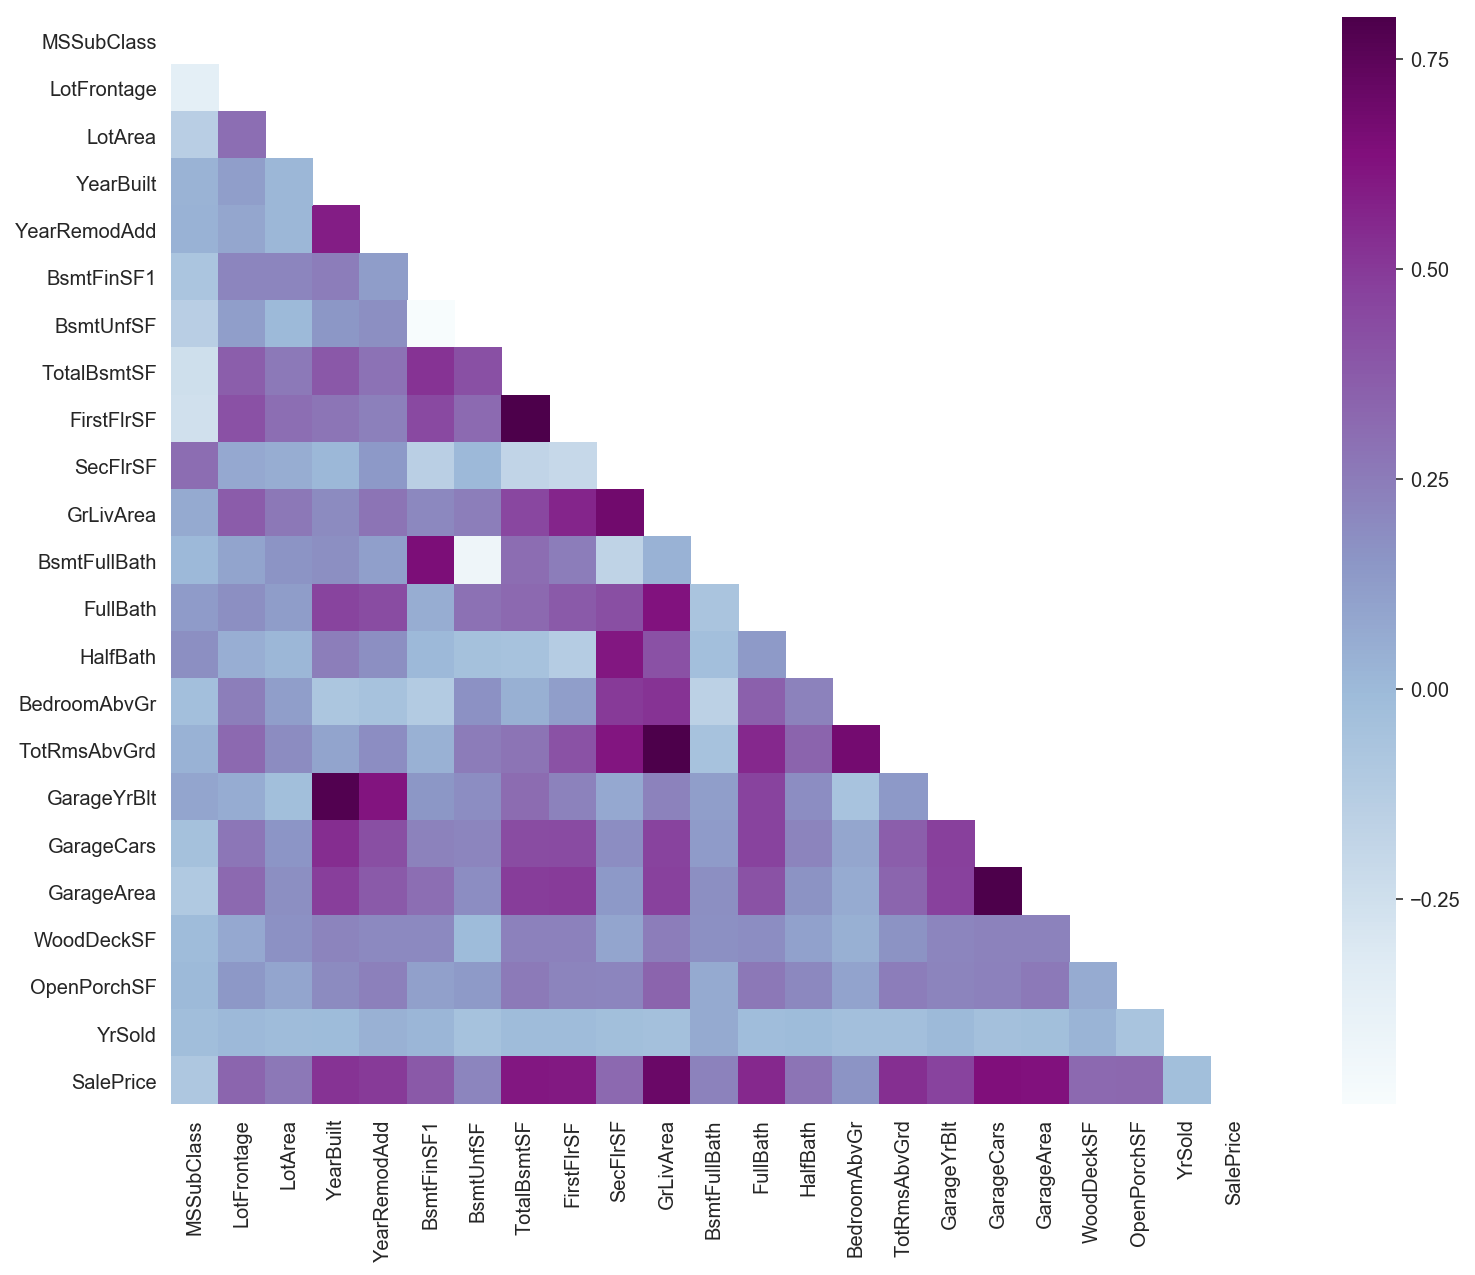

In [22]:
# correlation heatmap of num data
house_num = house_e.select_dtypes(exclude='object')
plt.figure(figsize=(15,10))
corr = house_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, cmap="BuPu", mask=mask, vmax=.8, square=True)

In [23]:
corr['SalePrice']

MSSubClass     -0.087487
LotFrontage     0.337514
LotArea         0.264715
YearBuilt       0.517602
YearRemodAdd    0.501186
BsmtFinSF1      0.384475
BsmtUnfSF       0.216152
TotalBsmtSF     0.612088
FirstFlrSF      0.603300
SecFlrSF        0.319774
GrLivArea       0.708658
BsmtFullBath    0.224054
FullBath        0.556674
HalfBath        0.280882
BedroomAbvGr    0.162008
TotRmsAbvGrd    0.533355
GarageYrBlt     0.467205
GarageCars      0.642135
GarageArea      0.629831
WoodDeckSF      0.320770
OpenPorchSF     0.329491
YrSold         -0.025391
SalePrice       1.000000
Name: SalePrice, dtype: float64

### Observations 
Strong correlations between:
###### FirstFlrSFand TotalBsmtSF:
Larger basement will mean a larger First Floor.
Only going to consider TotalBsmtSF as it has a slightly higher correlation with price

##### TotRmsAbvGrd and GrLivArea: 
Highly correlated, indicates similar data about the house.
Only going to consider GrLivArea as it is more correlated with price

##### SecFlrSF and GrLivArea: 
Indicates similar data about the house.
Only going to consider GrLivArea as it is more correlated with price

##### TotRmsAbvGrd and BedroomAbvGr:
Total rooms includes bedrooms. 
Ignoring bedrooms as it is repeated data

##### GarageArea and GarageCars: 
Repeated data. 
Only going to consider GarageCars as it has a slightly higher correlation with price


In [24]:
house_e.drop('FirstFlrSF',axis=1,inplace=True)
house_e.drop('BedroomAbvGr',axis=1,inplace=True)
house_e.drop('SecFlrSF',axis=1,inplace=True)
house_e.drop('GarageArea',axis=1,inplace=True)

In [25]:
house_e.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'LotConfig',
       'Neighborhood', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'Foundation',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'GarageType',
       'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'YrSold',
       'SalePrice'],
      dtype='object')

# Modelling



##### 1. Create models

In [26]:
# define a function to create and score models
def create_train_test_scale_fit(data, model_type, target):
    """Returns score, y_pred_lasso, y_test, X, coefs"""
    # create X, y
    f = f'{target} ~ '+' + '.join([c for c in data.columns])+' - 1'
    y, X = patsy.dmatrices(f, data=data, return_type='dataframe')
    
    # create train (before 2010) test (2010) split
    X_train = X[X['YrSold'] != 2010].drop([target,'YrSold'],axis=1)
    y_train = X[X['YrSold'] != 2010][target]

    X_test = X[X['YrSold'] == 2010].drop([target,'YrSold'],axis=1)
    y_test = X[X['YrSold'] == 2010][target]
    
    # scale
    ss = StandardScaler()
    ss.fit(X_train)
    Xs_train = ss.transform(X_train)
    Xs_test = ss.transform(X_test)

    # fit and score
    model = model_type
    model.fit(Xs_train, y_train)
    score = model.score(Xs_test, y_test)
    y_pred = model.predict(Xs_test)
    coefs = model.coef_
    
    return score, y_pred, y_test, X, coefs

##### 2. Model 1

In [27]:
# run function for linear regression
lrscore, lry_pred, lry_test, lrX, lrcoefs = create_train_test_scale_fit(house_e, model_type=LinearRegression(),
                                                              target='SalePrice')

In [28]:
#linear regression score
lrscore

0.8457753628083176

##### 3. Model 2

In [29]:
# run function for lasso
lasscore, lasy_pred, lasy_test, lasX, lascoefs = create_train_test_scale_fit(house_e, model_type=LassoCV(cv=100),
                                                              target='SalePrice')

In [30]:
#lasso score
lasscore

0.8480685888753894

### Observations
Model 2 is slightly better than Model 1

##### 4. plot model 2 residuals

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


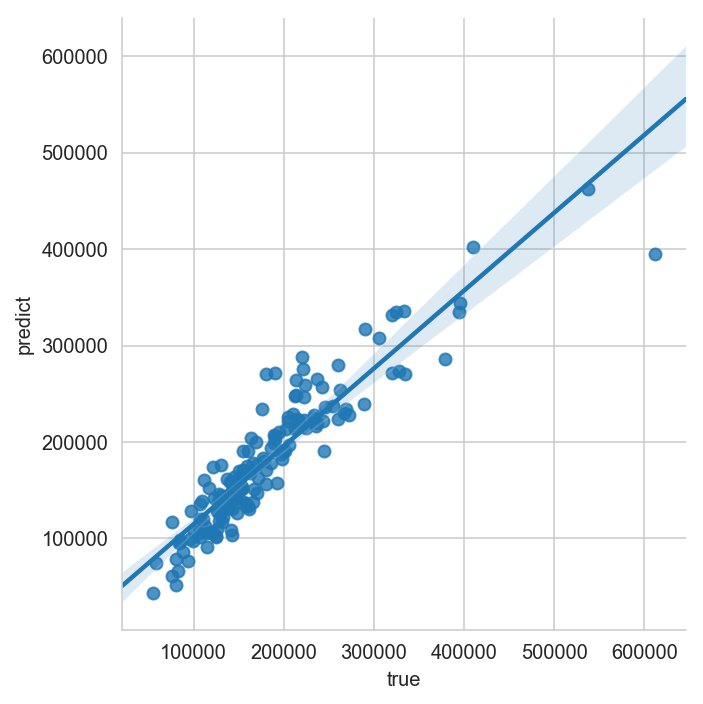

In [31]:
residual_plot = pd.DataFrame(list(zip(lasy_pred,lasy_test)), columns=['predict','true'])
sns.lmplot(x= 'true', y='predict', data=residual_plot)

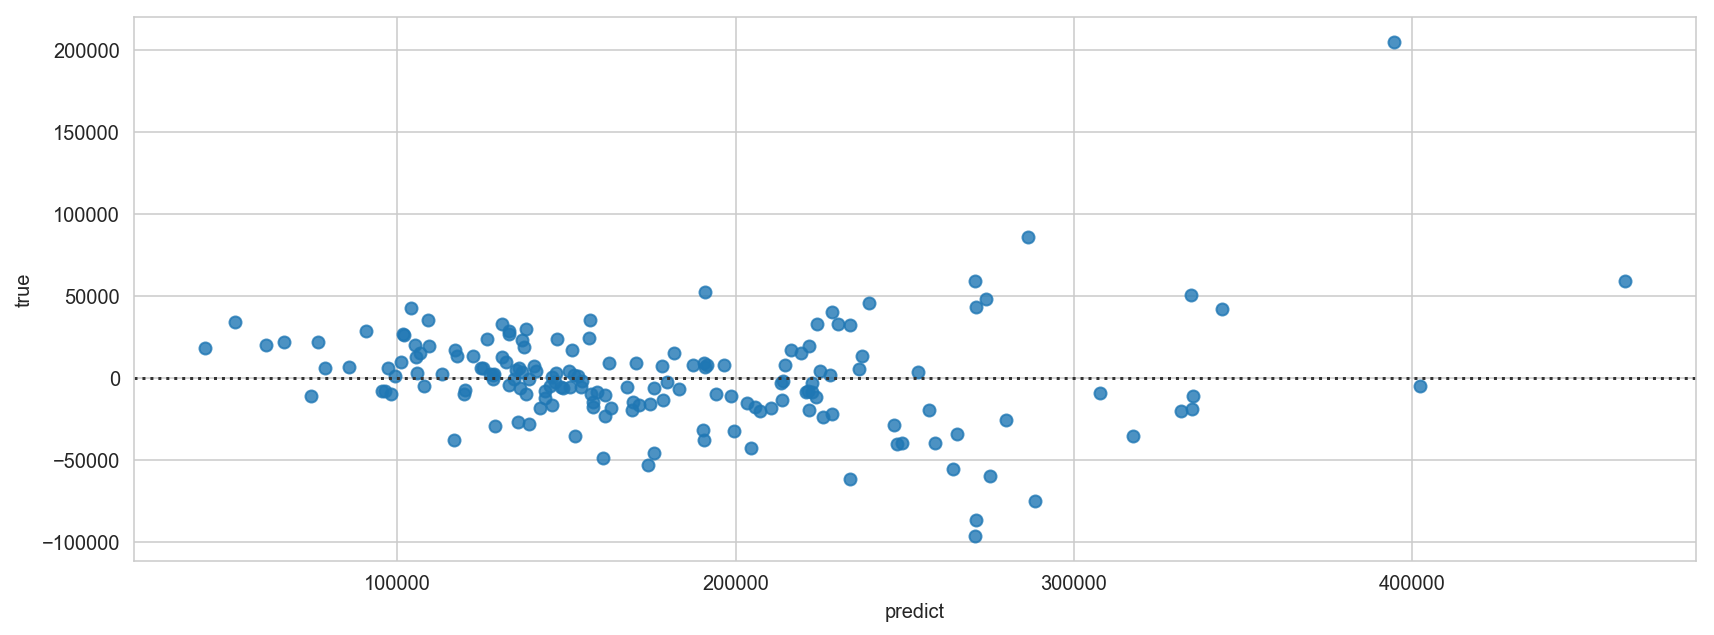

In [32]:
plt.figure(figsize=(14,5))
sns.residplot(x= 'predict', y='true', data=residual_plot)

### Observations
residuals are not randomly scattered - multicolinearity issue?

going to log sale price

##### 4. try loging data

In [33]:
# add the log of the saleprice as a new column and drop the original saleprice
house_e['SalePrice_lg'] = np.log(house_e['SalePrice'])

In [34]:
house_e2 = house_e.drop('SalePrice', axis=1)

##### 5. Model 3

In [35]:
# run function for lasso
lasscore2, lasy_pred2, lasy_test2, lasX2, lascoefs2 = create_train_test_scale_fit(house_e2, model_type=LassoCV(cv=100),
                                                              target='SalePrice_lg')

In [36]:
#lasso score
lasscore2

0.8907806609280761

### Observations 
better score

##### 6. plot model 3 residuals

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


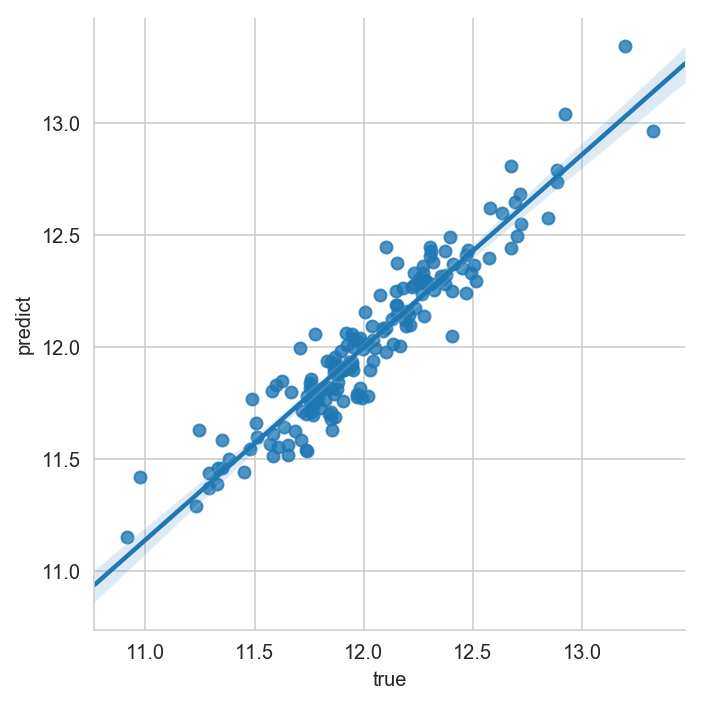

In [37]:
residual_plot = pd.DataFrame(list(zip(lasy_pred2,lasy_test2)), columns=['predict','true'])
sns.lmplot(x= 'true', y='predict', data=residual_plot)

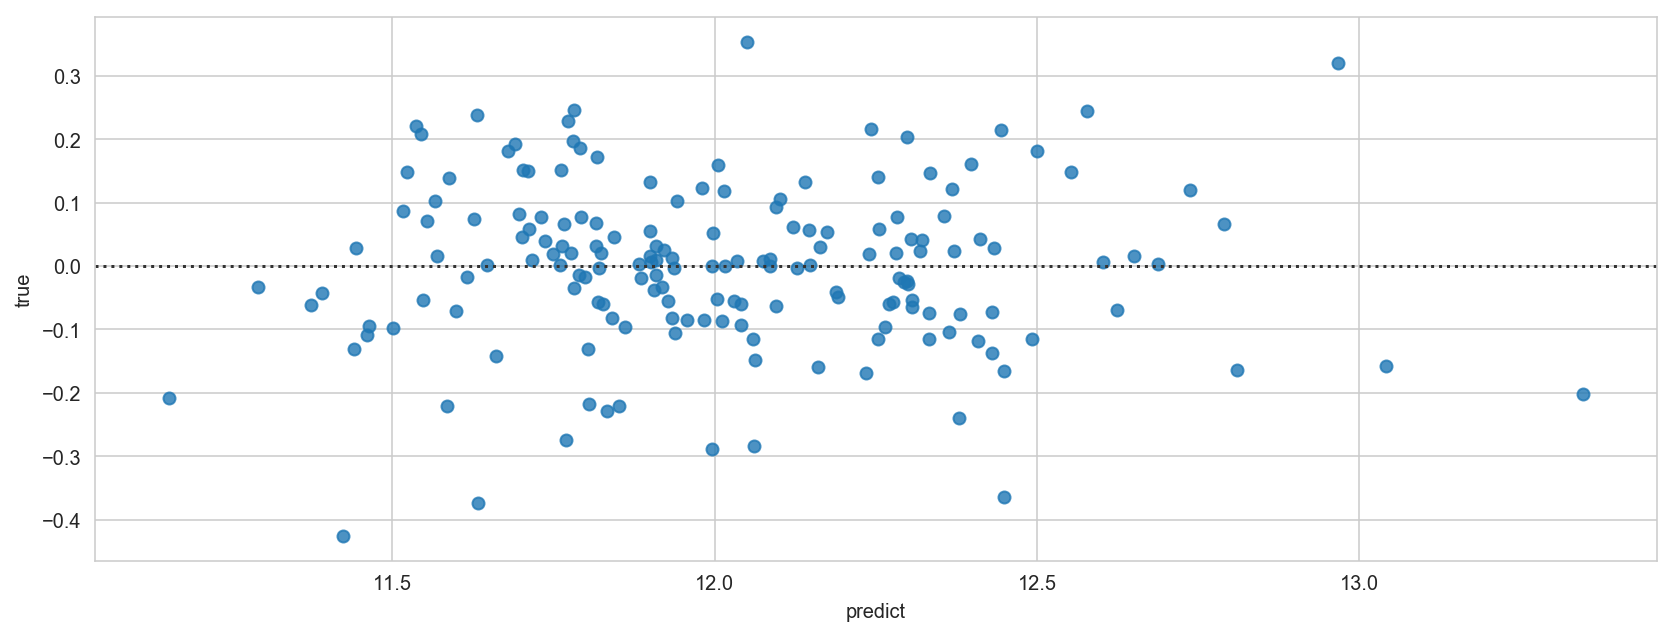

In [38]:
plt.figure(figsize=(14,5))
sns.residplot(x= 'predict', y='true', data=residual_plot)

### Observations
residuals are now randomly scattered - multicolinearity issue resolved

# Feature Engineering

In [39]:
#  Yard Area

YardArea = house['LotArea'] - house['FirstFlrSF'] - house['GarageArea']
YardArea = pd.DataFrame(YardArea,index=house.index.tolist())
YardArea.columns=['YardArea']

# bed bath ratio - above ground
BathBedRatio =  (house['FullBath'] + 0.5 * house['HalfBath'])/(house['BedroomAbvGr'] + 1)
BathBedRatio = pd.DataFrame(BathBedRatio,index=house.index.tolist())
BathBedRatio.columns=['BathBedRatio']


In [40]:
# identify extra big houses (outliers)
# identify houses with 'LotArea' > or < 6 std away from mean
thres = 6 * house['LotArea'].std()
lotarea_mask = abs( house['LotArea'] - house['LotArea'].mean() ) > thres
house_e2['big_house'] = 0
house_e2.loc[lotarea_mask, 'big_house'] = 1

# dummify big houses
big_house = pd.get_dummies(house_e2['big_house'], drop_first=True)
big_house.columns= ['big_house']

#drop original big house from df
house_e2.drop('big_house', axis=1, inplace=True)

# do not have enough domain knowledge to determine any other potential Features

In [41]:
house_e2_new = pd.concat([house_e2,YardArea, BathBedRatio,big_house], axis=1)


# Model 4 = Feature Engineering + Model 3

In [42]:
# run function for lasso
lasscore3, lasy_pred3, lasy_test3, lasX3, lascoefs3 = create_train_test_scale_fit(house_e2_new, model_type=LassoCV(cv=100),
                                                              target='SalePrice_lg')

In [43]:
#lasso score
lasscore3

0.8911660836676876

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


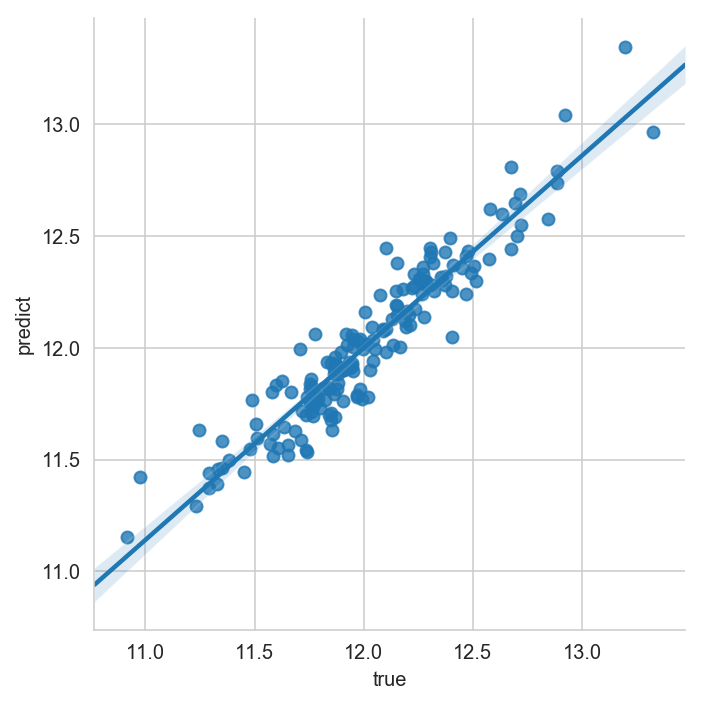

In [44]:
residual_plot = pd.DataFrame(list(zip(lasy_pred2,lasy_test2)), columns=['predict','true'])
sns.lmplot(x= 'true', y='predict', data=residual_plot)

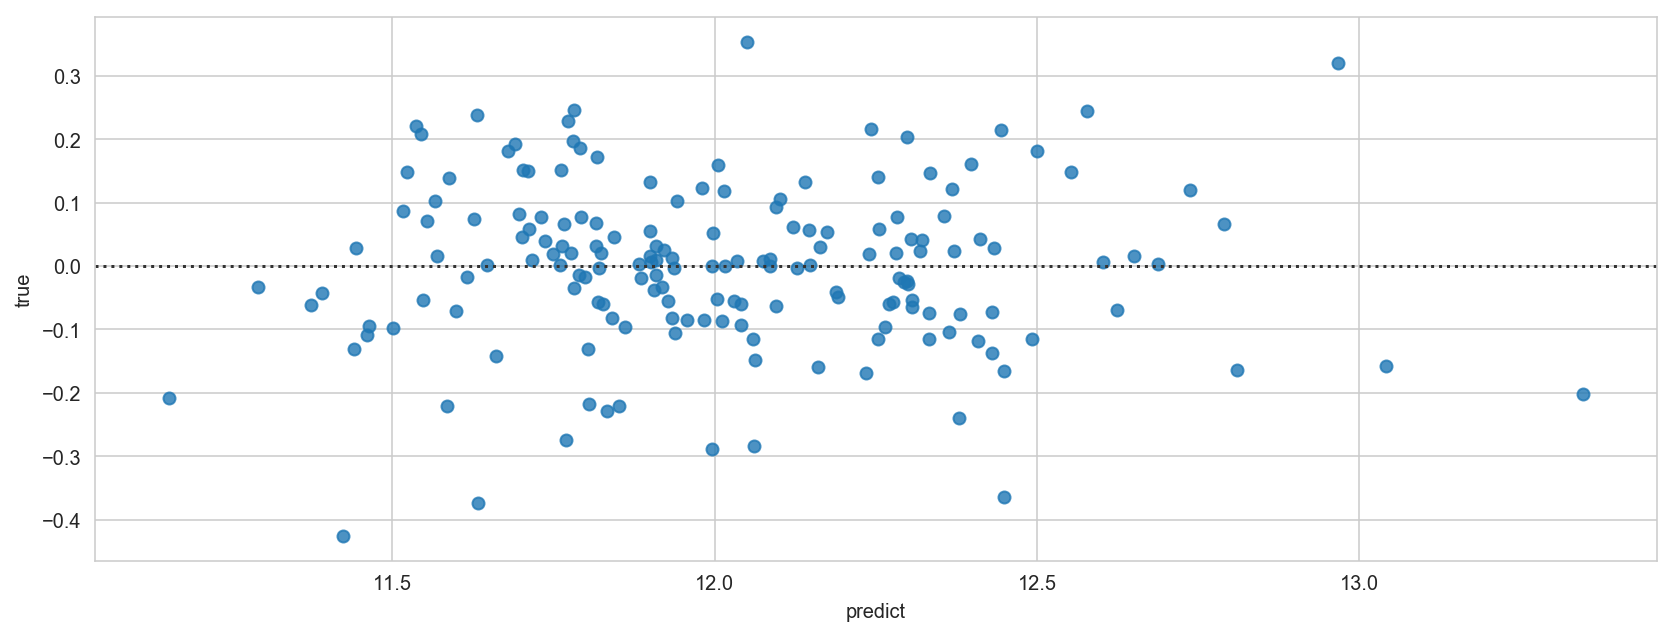

In [45]:
plt.figure(figsize=(14,5))
sns.residplot(x= 'predict', y='true', data=residual_plot)

### Observations
Model 4 is the best model new features slightly increase the score
Model 4 predicts with an 89% accuracy

# Strong Predictors

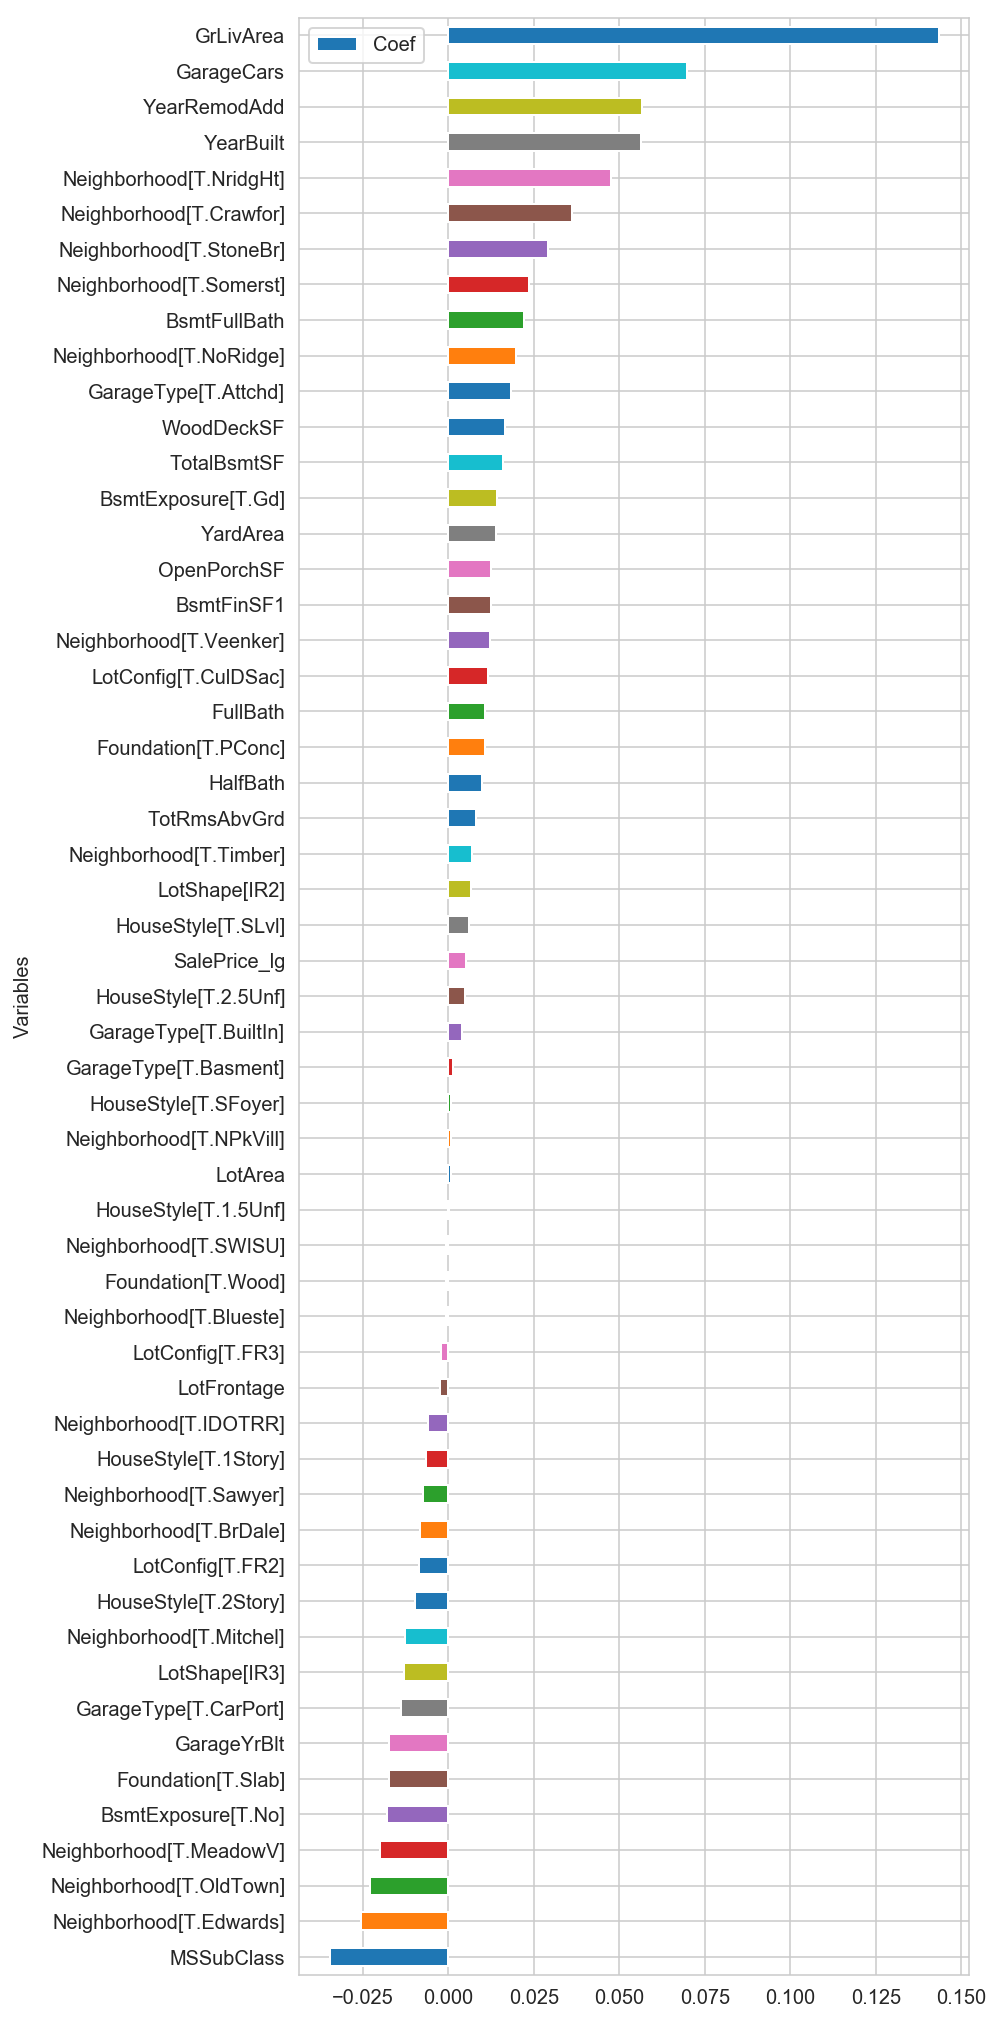

In [46]:
# create a df of Model 4 coefs and graph it
Model4_coefs = pd.DataFrame(list(zip(lasX3.columns, lascoefs3)), columns=['Variables','Coef'])
Model4_coefs = Model4_coefs.loc[(Model4_coefs['Coef'] != 0)]
Model4_coefs.sort_values('Coef', ascending=True).plot(x='Variables',y='Coef',figsize=(6,18), kind='barh')


In [47]:
#Top 10 predictors of price
Model4_coefs['Coef_abs'] = Model4_coefs['Coef'].abs()
Model4_coefs.sort_values('Coef_abs', ascending=False).head(10)

,Variables,Coef,Coef_abs
60,GrLivArea,0.143358,0.143358
66,GarageCars,0.069763,0.069763
56,YearRemodAdd,0.056534,0.056534
55,YearBuilt,0.056373,0.056373
23,Neighborhood[T.NridgHt],0.047675,0.047675
13,Neighborhood[T.Crawfor],0.036076,0.036076
52,MSSubClass,-0.034699,0.034699
29,Neighborhood[T.StoneBr],0.029240,0.029240
14,Neighborhood[T.Edwards],-0.025597,0.025597
28,Neighborhood[T.Somerst],0.023540,0.023540


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

# Identify Changeable

In [48]:
# changeable features + SalePrice and YrSold
change = ['OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType','ExterQual',
          'BsmtQual', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'Fireplaces', 'GarageFinish', 'YrSold','SalePrice']


In [49]:
house_est = house[change]

# EDA Changeable

In [50]:
# Convert ranked columns to numbers
dict_type = {'Ex': 5, 'Gd': 4, 'TA': 3,'Fa': 2,'Po': 1,
              'GLQ': 6, 'ALQ': 5, 'BLQ': 4,'Rec': 3, 'LwQ': 2,
              'Unf': 1, 'Fin': 3, 'RFn': 2,}
for col in ['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual','BsmtFinType1','GarageFinish']:
    house_est.loc[:, col] = house_est[col].apply(lambda x: dict_type[x] if x in dict_type else 0).copy()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [51]:
house_est.head()

,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,BsmtQual,BsmtFinType1,HeatingQC,KitchenQual,Fireplaces,GarageFinish,YrSold,SalePrice
0,7,5,Gable,VinylSd,VinylSd,BrkFace,4,4,6,5,4,0,2,2008,208500
1,6,8,Gable,MetalSd,MetalSd,None,3,4,5,5,3,1,2,2007,181500
2,7,5,Gable,VinylSd,VinylSd,BrkFace,4,4,6,5,4,1,2,2008,223500
3,7,5,Gable,Wd Sdng,Wd Shng,None,3,3,5,4,4,1,1,2006,140000
4,8,5,Gable,VinylSd,VinylSd,BrkFace,4,4,6,5,4,1,2,2008,250000


In [52]:
house_est.isnull().sum()

OverallQual     0
OverallCond     0
RoofStyle       0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
ExterQual       0
BsmtQual        0
BsmtFinType1    0
HeatingQC       0
KitchenQual     0
Fireplaces      0
GarageFinish    0
YrSold          0
SalePrice       0
dtype: int64

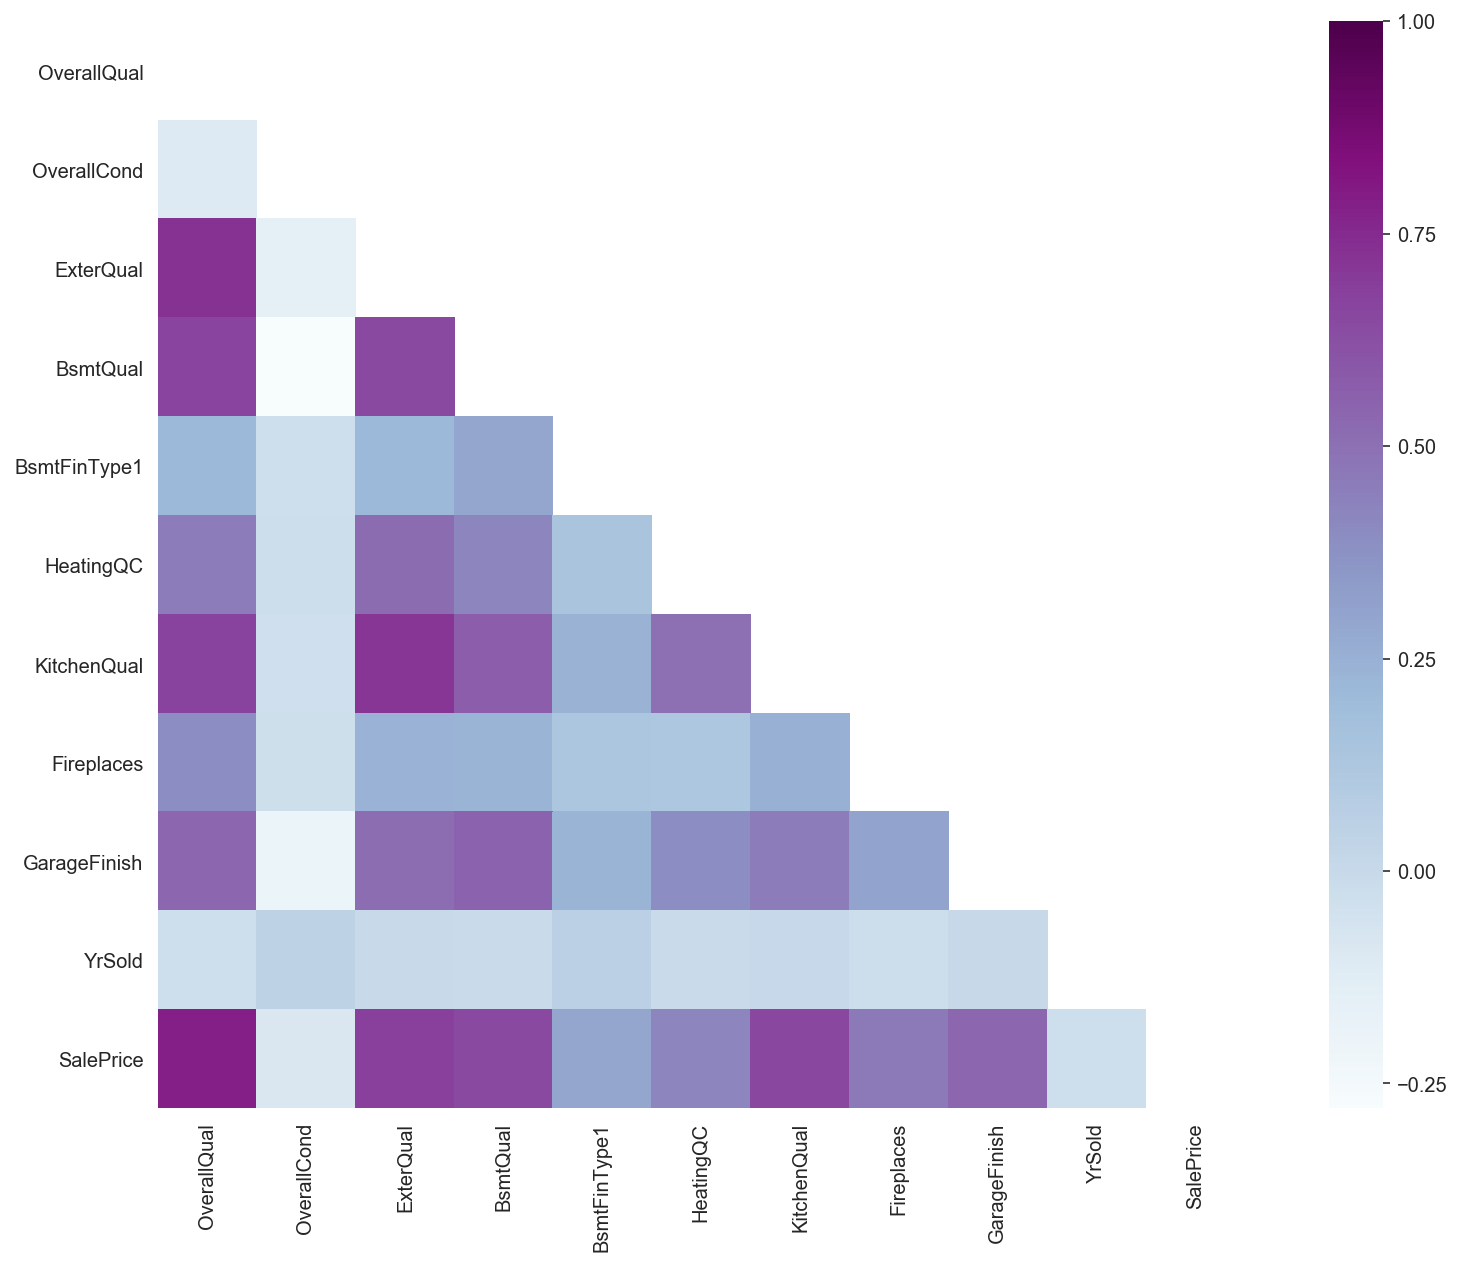

In [53]:
plt.figure(figsize=(15,10))
corr = house_est.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, cmap="BuPu", mask=mask, square=True)

### Observations
##### ExterQual, BsmtQual, KitchenQual and OverallQual:
Highly correlated.
OverallQual is repeated data of ExterQual, BsmtQual, KitchenQual added together
Dropping OverallQual


In [54]:
house_est.drop('OverallQual', axis=1,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Model Changeable Features only 

In [55]:
house_est['SalePrice_lg'] = np.log(house_est['SalePrice'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [56]:
house_est2 = house_est.drop('SalePrice', axis=1)

In [57]:
score4, lasy_pred4, lasy_test4, lasX4, lascoefs4 = create_train_test_scale_fit(house_est, model_type=LassoCV(cv=100),
                                                              target='SalePrice_lg')

In [58]:
score4

0.9238020916996483

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


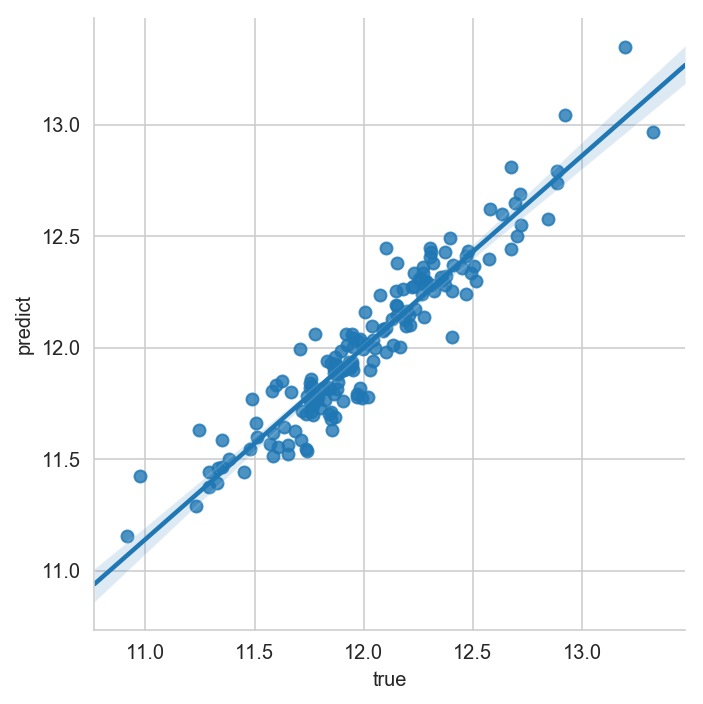

In [59]:
residual_plot2 = pd.DataFrame(list(zip(lasy_pred4,lasy_test4)), columns=['predict','true'])
sns.lmplot(x= 'true', y='predict', data=residual_plot)

### Observations
Changeable features only predict 92% of logged SalePrice

# Model Fixed and Changeable Features

In [60]:
house_est.drop('SalePrice_lg',axis=1, inplace=True)
house_est.drop('SalePrice',axis=1, inplace=True)
house_est.drop('YrSold',axis=1, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [61]:
house_price= pd.concat([house_est,house_e2_new],axis=1)

In [62]:
score5, lasy_pred5, lasy_test5, lasX5, lascoefs5 = create_train_test_scale_fit(house_price, model_type=LassoCV(cv=100),
                                                              target='SalePrice_lg')

In [63]:
score5

0.8978192798719877

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


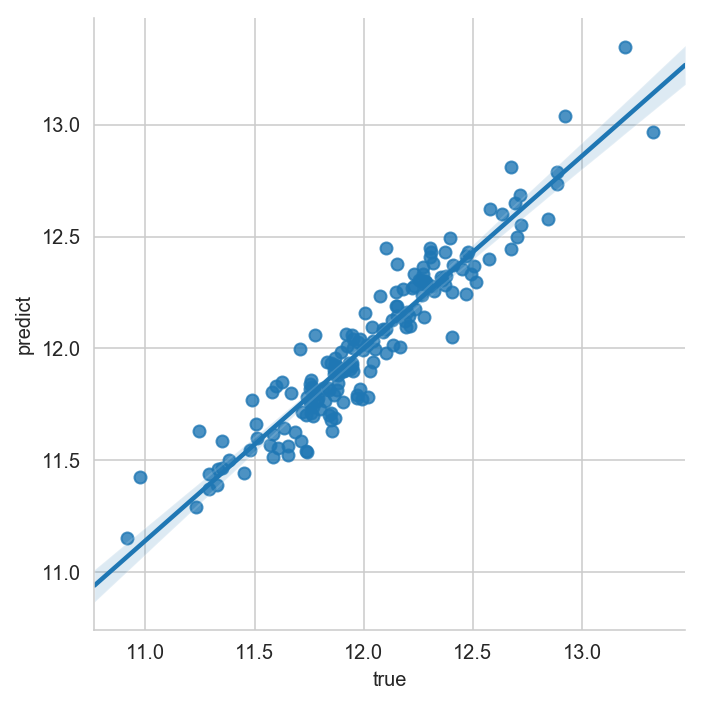

In [64]:
residual_plot3 = pd.DataFrame(list(zip(lasy_pred5,lasy_test5)), columns=['predict','true'])
sns.lmplot(x= 'true', y='predict', data=residual_plot)

In [75]:
Model5_coefs = pd.DataFrame(list(zip(lasX5.columns, lascoefs5)), columns=['Variables','Coef'])
Model4_coefs['Coef_abs'] = Model4_coefs['Coef'].abs()
Model4_coefs.sort_values('Coef_abs', ascending=False).head(20)

,Variables,Coef,Coef_abs
60,GrLivArea,0.143358,0.143358
66,GarageCars,0.069763,0.069763
56,YearRemodAdd,0.056534,0.056534
55,YearBuilt,0.056373,0.056373
23,Neighborhood[T.NridgHt],0.047675,0.047675
13,Neighborhood[T.Crawfor],0.036076,0.036076
52,MSSubClass,-0.034699,0.034699
29,Neighborhood[T.StoneBr],0.029240,0.029240
14,Neighborhood[T.Edwards],-0.025597,0.025597
28,Neighborhood[T.Somerst],0.023540,0.023540


### Observations
all features predict 89% of logged SalePrice, slightly better than Model 4

In [65]:
# find dollar value of residuals in Model 4 (fixed features)
residual_plot['FixedPredict'] = residual_plot['predict'].map(exp)
residual_plot['true_value'] = residual_plot['true'].map(exp)
residual_plot['FixedResidual'] = abs(residual_plot['true_value'] - residual_plot['FixedPredict'])
residual_plot.head()

,predict,true,FixedPredict,true_value,FixedResidual
0,11.899640,11.911702,147213.681912,149000.0,1786.318088
1,11.920865,11.944708,150371.620581,154000.0,3628.379419
2,11.820999,11.811547,136080.104327,134800.0,1280.104327
3,12.601542,12.631340,297016.120215,306000.0,8983.879785
4,12.015728,12.016726,165334.753263,165500.0,165.246737


In [66]:
# find dollar value of residuals in Changeable Model
residual_plot2['ChangePredicted'] = residual_plot2['predict'].map(exp)
residual_plot2['true_value'] = residual_plot2['true'].map(exp)
residual_plot2['ChangeResidual'] = abs(residual_plot2['true_value'] - residual_plot2['ChangePredicted'])
residual_plot2.head()

,predict,true,ChangePredicted,true_value,ChangeResidual
0,11.963953,11.911702,156992.427901,149000.0,7992.427901
1,12.002383,11.944708,163143.087360,154000.0,9143.087360
2,11.770961,11.811547,129438.436584,134800.0,5361.563416
3,12.621836,12.631340,303105.385157,306000.0,2894.614843
4,11.969185,12.016726,157815.912083,165500.0,7684.087917


In [67]:
# find dollar value of residuals in Combined Model
residual_plot3['CombPredicted'] = residual_plot3['predict'].map(exp)
residual_plot3['true_value'] = residual_plot3['true'].map(exp)
residual_plot3['CombResidual'] = abs(residual_plot3['true_value'] - residual_plot3['CombPredicted'])
residual_plot3.head()

,predict,true,CombPredicted,true_value,CombResidual
0,11.998176,11.911702,162458.199039,149000.0,13458.199039
1,12.014216,11.944708,165085.048683,154000.0,11085.048683
2,11.833001,11.811547,137723.196536,134800.0,2923.196536
3,12.571609,12.631340,288257.275268,306000.0,17742.724732
4,12.116574,12.016726,182877.971008,165500.0,17377.971008


In [68]:
#concatentate claculated variables
compare_mod = pd.concat([residual_plot['true_value'],residual_plot['FixedPredict'],
                         residual_plot2['ChangePredicted'],residual_plot3['CombPredicted']], axis=1)
compare_mod.head()

,true_value,FixedPredict,ChangePredicted,CombPredicted
0,149000.0,147213.681912,156992.427901,162458.199039
1,154000.0,150371.620581,163143.087360,165085.048683
2,134800.0,136080.104327,129438.436584,137723.196536
3,306000.0,297016.120215,303105.385157,288257.275268
4,165500.0,165334.753263,157815.912083,182877.971008


In [69]:
# calculate diff between predicted and actual
compare_mod['FixedDiff'] = compare_mod['true_value']-compare_mod['FixedPredict']
compare_mod['ChangeDiff'] = compare_mod['true_value']-compare_mod['ChangePredicted']
compare_mod['CombDiff'] = compare_mod['true_value']-compare_mod['CombPredicted']
compare_mod.head()   

,true_value,FixedPredict,ChangePredicted,CombPredicted,FixedDiff,ChangeDiff,CombDiff
0,149000.0,147213.681912,156992.427901,162458.199039,1786.318088,-7992.427901,-13458.199039
1,154000.0,150371.620581,163143.087360,165085.048683,3628.379419,-9143.087360,-11085.048683
2,134800.0,136080.104327,129438.436584,137723.196536,-1280.104327,5361.563416,-2923.196536
3,306000.0,297016.120215,303105.385157,288257.275268,8983.879785,2894.614843,17742.724732
4,165500.0,165334.753263,157815.912083,182877.971008,165.246737,7684.087917,-17377.971008


In [70]:
#compare average difference between predicted and actual of the three models

print('fixed features difference in price is ' +str(compare_mod['FixedDiff'].mean()))
print('changable features difference in price is ' +str(compare_mod['ChangeDiff'].mean()))
print('combined features difference in price is ' +str(compare_mod['CombDiff'].mean()))

fixed features difference in price is 2427.989649390284
changable features difference in price is -2680.511269430415
combined features difference in price is 1807.8918638755672


In [71]:
compare_mod['FixedDiff'].mean()-compare_mod['CombDiff'].mean()

620.0977855147166

### Observations

The predicted price of the combined model is on average 620 closer to the true sale price of the property.
From a business perspective 620 is insignificant.

Fixed Model R^2: 0.891 and Combined Model R^2: 0.897

The changeable features explain 0.6% more of the variance, on top of Fixed Model.

While this model can be used to get a closer prediction on the worth of a house when buying, it does not help in choosing houses to buy renovate and resell at a higher price. In order to make this model more accurate and hopefully better able to predict the return sale price of a renovation project, access to someone with more domain knowledge then myself is required. 


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: